<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/tf_handBbox_esitmation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this task we want to localize the right and left hands for each person that exists in a single frame. 

# Download The Dataset

We use the dataset fromt his [project](https://lmb.informatik.uni-freiburg.de/projects/hand3d/). Each single frame contains the pose estimation of each hand. We use that to extract a tight box for each hand.  

In [1]:
!wget https://lmb.informatik.uni-freiburg.de/data/RenderedHandpose/RHD_v1-1.zip

--2019-02-16 12:34:41--  https://lmb.informatik.uni-freiburg.de/data/RenderedHandpose/RHD_v1-1.zip
Resolving lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)... 132.230.167.23
Connecting to lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)|132.230.167.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7080690299 (6.6G) [application/zip]
Saving to: ‘RHD_v1-1.zip’

RHD_v1-1.zip        100%[===================>]   6.59G  37.6MB/s    in 3m 27s  

2019-02-16 12:38:08 (32.7 MB/s) - ‘RHD_v1-1.zip’ saved [7080690299/7080690299]



In [0]:
!unzip RHD_v1-1.zip >> tmp.txt

In [0]:
import os 
os.chdir('RHD_published_v2')

# Extract the Bounding Boxes 

At each image there exists at most to hands left and right, we normalize them and extract a tight bounding box for each hand then for each file we save the vector [boxL , boxR] where boxL is the bounding box for the left hand and boxR is the box for the right hand. 

In [0]:
from PIL import Image  
import pickle
import os
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

def get_bb(proj, size, vis):
  w, h = size
  
  proj = proj[vis== 1]
  if len(proj) == 0:
    return [0, 0, 0, 0]
  xmin = np.min(proj[:,0])
  ymin = np.min(proj[:,1]) 
  xmax = np.max(proj[:,0])
  ymax = np.max(proj[:,1]) 
  
  
  box = [xmin/w, ymin/h, xmax/w, ymax/h]
  return box

# chose between training and evaluation set
# set = 'training'
set = 'training'
data = {}

# load annotations of this set
with open(os.path.join(set, 'anno_%s.pickle' % set), 'rb') as fi:
    anno_all = pickle.load(fi)

i = 0 
# iterate samples of the set
for sample_id, anno in anno_all.items():
    # get info from annotation dictionary
    kp_coord_uv = anno['uv_vis'][:, :2]  # u, v coordinates of 42 hand keypoints, pixel
    kp_visible = (anno['uv_vis'][:, 2] == 1)  # visibility of the keypoints, boolean
    kp_coord_xyz = anno['xyz']  # x, y, z coordinates of the keypoints, in meters
    camera_intrinsic_matrix = anno['K']  # matrix containing intrinsic parameters

    # Project world coordinates into the camera frame
    kp_coord_uv_proj = np.matmul(kp_coord_xyz, np.transpose(camera_intrinsic_matrix))
    kp_coord_uv_proj = kp_coord_uv_proj[:, :2] / kp_coord_uv_proj[:, 2:]
    
    #estimate bbox for the lefthand 
    path = os.path.join(set, 'color', '%.5d.png' % sample_id)
    
    img = Image.open(path)
    w, h = img.size

    leftbb = get_bb(kp_coord_uv_proj[0:21,:], (w,h), anno['uv_vis'][0:21, 2])
    rightbb = get_bb(kp_coord_uv_proj[21:, :], (w,h), anno['uv_vis'][21:, 2])
    
    
    if max(leftbb) > 1 or max(rightbb) > 1:
      continue
   
    data[path] = leftbb+rightbb

In [4]:
len(data)

41245

# Imports

We use tensorflow with eager execution. Hence, eager execution allows immediate evaluation of tensors without instintiating graph. 

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape, GlobalAveragePooling2D, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
import tensorflow.contrib.eager as tfe

In [0]:
tf.enable_eager_execution()

#Create A Dataset

Here we use `tf.data` for manipulating the data and use them for training

In [0]:
def parse_data(filename, label):
  
  image = tf.image.decode_jpeg(tf.read_file(filename), channels = 3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  image = tf.image.resize_images(image, [IMG_SIZE, IMG_SIZE])
  
  label = tf.cast(label, tf.float32)
  
  return image, label

In [0]:
def create_dataset(ff, ll):

  dataset = tf.data.Dataset.from_tensor_slices((ff, ll)).shuffle(len(ff) - 1)
  dataset = dataset.map(parse_data, num_parallel_calls = 4)
  dataset = dataset.batch(BATCH_SIZE)
  
  return dataset

# Data Split

We create a 10% split for the test data to be used for validation 

In [0]:
files = list(data.keys())
labels = list(data.values())

N = len(files)
M = int(0.9 * N)

#split files for images 
train_files = files[:M]
test_files  = files[M:]

#split labels
train_labels = labels[:M]
test_labels =  labels[M:]

In [10]:
print('training', len(train_files))
print('testing' , len(test_files))

training 37120
testing 4125


In [0]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_dataset = create_dataset(train_files, train_labels)
test_dataset = create_dataset(test_files, test_labels)

# Visualization 

In [0]:
def plot_annot(img, boxes):  

  img = img.numpy()
  boxes = boxes.numpy() * IMG_SIZE
  
  leftbb = boxes[0:4]
  rightbb = boxes[4:]

  img = cv2.rectangle(img, (int(leftbb[0]), int(leftbb[1])), (int(leftbb[2]), int(leftbb[3])), (1, 0, 0), 2)
  img = cv2.rectangle(img, (int(rightbb[0]), int(rightbb[1])), (int(rightbb[2]), int(rightbb[3])), (0, 0, 1), 2)


  plt.axis('off')
  plt.imshow(img)
  plt.show()

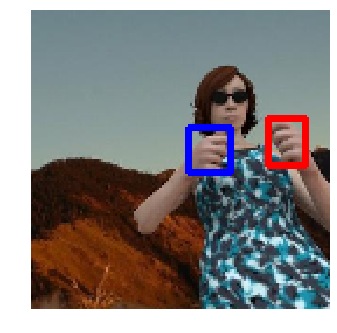

In [15]:
for x, y in train_dataset:
  plot_annot(x[0], y[0])
  break

# Create a model 

We use a ResNet model with 12 convolutiona layer. At the end we flatten the features and output a vector of size 8 for the bounding box predictions for each hand. 

In [0]:
def conv_block(fs, x, activation = 'relu'):
  conv  = Conv2D(fs, (3, 3), padding = 'same', activation = activation)(x)
  bnrm   = BatchNormalization()(conv)
  return bnrm

def residual_block(fs, x):
  y = conv_block(fs, x)
  y = conv_block(fs, y)
  return Concatenate(axis = -1)([x, y])

In [17]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))

block1 = residual_block(16, inp)
pool1  = MaxPooling2D(pool_size = (2, 2))(block1)
block2 = residual_block(32, pool1)
pool2  = MaxPooling2D(pool_size = (2, 2))(block2)
block3 = residual_block(64, pool2)
pool3  = MaxPooling2D(pool_size = (2, 2))(block3)
block4 = residual_block(128, pool3)
pool4  = MaxPooling2D(pool_size = (2, 2))(block4)
block5 = residual_block(256, pool4)
pool5  = MaxPooling2D(pool_size = (2, 2))(block5)
block6 = residual_block(512, pool5)
pool6  = MaxPooling2D(pool_size = (2, 2))(block6)

flatten = Flatten()(pool6)

dense = Dense(256, activation = 'relu')(flatten)
droput = Dropout(0.5)(dense)
out = Dense(8, activation = 'sigmoid')(droput)

#create a model with one input and two outputs 
model = tf.keras.models.Model(inputs = inp, outputs = out)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_norm

# Loss and gradient 

In [0]:
def loss(pred, y):  
  return tf.losses.absolute_difference(y, pred) 
           
def grad(model, x, y):
  #record the gradient
  with tf.GradientTape() as tape:
    pred = model(x)
    value = loss(pred, y)
  #return the gradient of the loss function with respect to the model variables 
  return tape.gradient(value, model.trainable_variables)

optimizer = tf.train.AdamOptimizer()

# Evaluation metric 

We use intersection over union to evaluate how good we are estimating the generatd bounding boxes.

In [21]:
def iou(boxA, boxB):
  #evaluate the intersection points 
  xA = tf.maximum(boxA[:, 0], boxB[:, 0])
  yA = tf.maximum(boxA[:, 1], boxB[:, 1])
  xB = tf.minimum(boxA[:, 2], boxB[:, 2])
  yB = tf.minimum(boxA[:, 3], boxB[:, 3])

  # compute the area of intersection rectangle
  interArea = tf.maximum(0, xB - xA + 1) * tf.maximum(0, yB - yA + 1)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
  boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

  #compute the union 
  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return tf.reduce_mean(interArea / unionArea)

def mean_iou(pred, y):
  boxLA = y[:, :4]  
  boxLB = pred[:,:4] 
  
  boxRA = y[:, 4:]
  boxRB = pred[:, 4:]
  
  return (iou(boxLA, boxLB) + iou(boxRA, boxRB))/2

tf.Tensor(1.0, shape=(), dtype=float32)


We record the metrics at each epoch

In [0]:
epochs = 50

#initialize the history to record the metrics 
train_loss_history = tfe.metrics.Mean('train_loss')
train_iou_history  = tfe.metrics.Mean('train_iou')

test_loss_history = tfe.metrics.Mean('test_loss')
test_iou_history  = tfe.metrics.Mean('test_iou')

best_iou = 0.0

In [0]:
for i in range(1, epochs + 1):
  
  for x, y in train_dataset:
    pred = model(x)
    grads = grad(model, x, y)

    #update the paramters of the model 
    optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step = tf.train.get_or_create_global_step())

    #record the metrics of the current batch 
    loss_value = loss(pred, y)
    iou_value  = mean_iou(pred, y)
    
    #calcualte the metrics of the current batch
    train_loss_history(loss_value)
    train_iou_history(iou_value)
    
  #loop over the test dataset 
  for x, y in test_dataset:
    pred = model(x)
    
    #calcualte the metrics of the current batch 
    loss_value = loss(pred, y)
    iou_value  = mean_iou(pred, y)
    
    #record the values of the metrics 
    test_loss_history(loss_value)
    test_iou_history(iou_value)
    
  #print out the results 
  print("epoch: [{0:d}/{1:d}], Train: [loss: {2:0.4f}, iou: {3:0.4f}], Test: [loss: {4:0.4f}, iou: {5:0.4f}]".
       format(i, epochs, train_loss_history.result(), train_iou_history.result(), 
              test_loss_history.result(), test_iou_history.result()))
  
  current_iou = test_iou_history.result().numpy()
  
  #save the best model 
  if best_iou  < current_iou:
    best_iou = current_iou
    print('saving best model with iou', best_iou)
    model.save('keras.h5')
    
  #clear the history after each epoch 
  train_loss_history.init_variables()
  train_iou_history.init_variables()
  
  test_loss_history.init_variables()
  test_iou_history.init_variables()

Save the best model

In [25]:
from tensorflow.keras.models import load_model
best_model = load_model('keras.h5')

# Visualization 

In [0]:
#visualize the predicted bounding box
def plot_pred(img_id):
  
  raw = cv2.imread(img_id)[:,:,::-1]
  
  h, w = (512, 512)
  
  img = cv2.resize(raw, (IMG_SIZE, IMG_SIZE)).astype('float32')
  img = np.expand_dims(img, 0)/255. 
  
  boxes = best_model(img).numpy()[0]

  raw = cv2.resize(raw, (w, h))
    
  leftbb = boxes[:4]*w
  rightbb = boxes[4:]*w
  
  print(leftbb)
  print(rightbb)
  img = cv2.rectangle(raw, (int(leftbb[0]), int(leftbb[1])), (int(leftbb[2]), int(leftbb[3])), (255, 0, 0), 3)
  img = cv2.rectangle(raw, (int(rightbb[0]), int(rightbb[1])), (int(rightbb[2]), int(rightbb[3])), (0, 0, 255), 3)


  plt.axis('off')
  plt.imshow(img)
  plt.show()

[478.8169  214.33978 508.4085  309.2115 ]
[257.33472 188.45944 385.61972 305.6182 ]


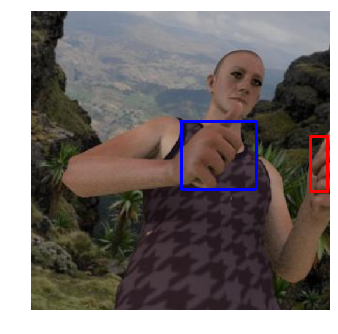

In [36]:
img_id = np.random.choice(test_files)
plot_pred(img_id)